In [ ]:
!pip install gymnasium
!pip install numpy
!pip install pygame
!pip install random
!pip install tqdm
!pip install matplotlib

In [1]:
import gymnasium as gym
import numpy as np
import pygame
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import sys

In [2]:
class MazeGameEnv(gym.Env):
    def __init__(self, maze):
        super(MazeGameEnv, self).__init__()
        self.maze = np.array(maze)
        self.start_pos = tuple(np.argwhere(self.maze == 'S')[0])
        self.goal_pos = tuple(np.argwhere(self.maze == 'G')[0])
        self.current_pos = self.start_pos
        self.num_rows, self.num_cols = self.maze.shape

        # Define ação como Discrete com 4 ações (cima, baixo, esquerda, direita)
        self.action_space = gym.spaces.Discrete(4)

        # Defina o espaço de observação como uma tupla com o número de linhas e colunas
        self.observation_space = gym.spaces.Tuple((gym.spaces.Discrete(self.num_rows), gym.spaces.Discrete(self.num_cols)))

        # Inicialize o ambiente Pygame
        pygame.init()

        # Defina cores
        self.WHITE = (255, 255, 255)
        self.GREEN = (0, 255, 0)
        self.RED = (255, 0, 0)
        self.BLACK = (0, 0, 0)
        self.PURPLE = (255, 0, 255)
        self.BLUE = (0, 0, 255)

    def reset(self, num_obstacles = 0, fixed_start_pos = None):
        self.reset_obstacles(num_obstacles)
        if fixed_start_pos is not None:
            row, col = fixed_start_pos
        else:
            row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            while self.maze[row, col] in ['#', 'G']:  # Garante que a posição inicial não é um obstáculo ou a posição final
                row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
        self.maze[self.start_pos] = '.'  # Limpa a posição inicial antiga
        self.start_pos = (row, col)
        self.maze[row, col] = 'S'  # Define a nova posição inicial
        self.current_pos = self.start_pos
        return self.current_pos
    
    def reset_obstacles(self, num_obstacles = 0):
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.maze[row, col] == 'R':
                    self.maze[row, col] = '.'
        
        for _ in range(num_obstacles):
            row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            while self.maze[row, col] in ['S', 'G', '#','R']:
                row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            self.maze[row, col] = 'R'

    def step(self, action, reward = 1):
        old_pos = self.current_pos
            
        if action == 0:  # Cima
            self.move('up')
        elif action == 1:  # Baixo
            self.move('down')
        elif action == 2:  # Esquerda
            self.move('left')
        elif action == 3:  # Direita
            self.move('right')

        obs = self.current_pos
        #
        # reward = 1 if self.current_pos == self.goal_pos else 0
        # distance_to_goal = abs(self.current_pos[0] - self.goal_pos[0]) + abs(self.current_pos[1] - self.goal_pos[1])
        # reward = 1 / (distance_to_goal + 1)
        # done = self.current_pos == self.goal_pos
        #
        max_distance = self.num_rows + self.num_cols - 2
        if self.current_pos == old_pos:
            reward = -max_distance  # Penalidade por ação inválida
            done = False
        else:
            if self.current_pos == self.goal_pos:
                reward = max_distance
                done = True
            else:
                distance_to_goal = abs(self.current_pos[0] - self.goal_pos[0]) + abs(self.current_pos[1] - self.goal_pos[1])
                reward = -1 + (1 - distance_to_goal / max_distance)
                # reward = -distance_to_goal
                done = False
            
        info = {}

        return obs, reward, done, info
    
    def move(self, action):
        new_pos = list(self.current_pos)

        if action == 'up':
            new_pos[0] -= 1
        elif action == 'down':
            new_pos[0] += 1
        elif action == 'left':
            new_pos[1] -= 1
        elif action == 'right':
            new_pos[1] += 1

        new_pos = tuple(new_pos)

        if self.is_valid_position(new_pos[0], new_pos[1]):
            self.current_pos = new_pos

    def is_valid_position(self, row, col):
        return 0 <= row < self.num_rows and 0 <= col < self.num_cols and self.maze[row, col] != '#' and self.maze[row, col] != 'R'


    def render(self, path=None):
        self.draw_maze(path)
        pygame.display.update()
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    pygame.quit()
                    sys.exit()

    def play_path(self, path, delay=0.5):
        for position in path:
            self.current_pos = position
            self.render(path = path)
            time.sleep(delay)

    def draw_maze(self, path = None):
        self.cell_size = 50
        self.screen_width = self.num_cols * self.cell_size
        self.screen_height = self.num_rows * self.cell_size
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        self.screen.fill(self.WHITE)
        
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                if self.maze[row, col] == '#' or self.maze[row, col] == 'R':
                    pygame.draw.rect(self.screen, self.BLACK, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':
                    pygame.draw.rect(self.screen, self.GREEN, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'G':
                    pygame.draw.rect(self.screen, self.RED, (cell_left, cell_top, self.cell_size, self.cell_size))
                    
        if path:
            for i in range(len(path)-1):
                start = path[i]
                end = path[i+1]
                self.draw_line(start, end)

        current_row, current_col = self.current_pos
        pygame.draw.rect(self.screen, self.PURPLE, (current_col * self.cell_size, current_row * self.cell_size, self.cell_size, self.cell_size))

    def draw_line(self, start, end):
        start_x = start[1] * self.cell_size + self.cell_size // 2
        start_y = start[0] * self.cell_size + self.cell_size // 2
        end_x = end[1] * self.cell_size + self.cell_size // 2
        end_y = end[0] * self.cell_size + self.cell_size // 2

        pygame.draw.line(self.screen, self.BLUE, (start_x, start_y), (end_x, end_y), 2)
        
    def draw_arrows(self, Q):
        arrow_image = pygame.image.load('arrow.png')  # Carrega a imagem da seta
        arrow_image = pygame.transform.scale(arrow_image, (self.cell_size, self.cell_size))  # Redimensiona para caber na célula

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                state = (row, col)
                if self.maze[row][col] in ['.', 'R']:  # Não desenhar em '#', 'S' ou 'G'
                    best_action = max(Q[state], key=Q[state].get)
                    center = (col * self.cell_size, row * self.cell_size)

                    if best_action == 0:  # Cima
                        rotated_image = pygame.transform.rotate(arrow_image, 90)
                    elif best_action == 1:  # Baixo
                        rotated_image = pygame.transform.rotate(arrow_image, -90)
                    elif best_action == 2:  # Esquerda
                        rotated_image = pygame.transform.rotate(arrow_image, 180)
                    elif best_action == 3:  # Direita
                        rotated_image = arrow_image  # Não precisa rotacionar

                    self.screen.blit(rotated_image, center)  # Desenha a imagem rotacionada


        
    def close(self):
        pygame.quit()


In [50]:
class MonteCarloAgent:
    def __init__(self, env, alpha = 0.05, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.Q = {}
        self.returns = {}  # Dicionário para armazenar retornos para cada estado-ação
        self.initialize_Q_and_returns()
    
    def initialize_Q_and_returns(self):
        for row in range(self.env.num_rows):
            for col in range(self.env.num_cols):
                self.Q[(row, col)] = {}
                self.returns[(row, col)] = {}
                for a in range(self.env.action_space.n):
                    # Inicialização ligeiramente aleatória para promover a exploração inicial
                    self.Q[(row, col)][a] = np.random.uniform(low=-0.1, high=0.1)
                    self.returns[(row, col)][a] = []

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return max(self.Q[state], key=self.Q[state].get)
    
    def learn(self, episode):
        G = 0
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            # Verifique se a combinação estado-ação não aparece no episódio
            if not (state, action) in [(x[0], x[1]) for x in episode[:-1]]:
                self.returns[state][action].append(G)
                self.Q[state][action] = np.mean(self.returns[state][action])

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def train(self, episodes, num_obstacles=0, render=False, max_steps=100):
        episodes_data = {}
        
        for episode_num in range(episodes):
            episode = []
            state = self.env.reset(num_obstacles)
            done = False
            total_reward = 0
            step_count = 0
            
            while not done and step_count < max_steps:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state
                total_reward += reward
                step_count += 1
                if render:
                    self.env.render()

            self.learn(episode)  # Aprendizado é feito após o término do episódio
            self.update_epsilon()  # Atualiza epsilon após cada episódio
            
            episodes_data[episode_num] = {
                'reward': total_reward,
                'steps': step_count,
                'path': [x[0] for x in episode]
            }
            
        if render:
            self.env.close()
            
        return episodes_data
    
    def execute_optimal_policy(self, max_steps=100, start_pos = None):
        state = self.env.reset(num_obstacles=0, fixed_start_pos = start_pos)
        path = [state]  # Iniciar o caminho com o estado inicial
        self.env.render(path=path)  # Passa o caminho atual para a função render
        step_count = 0
        done = False
        while not done and step_count < max_steps:
            action = max(self.Q[state], key=self.Q[state].get)
            next_state, reward, done, _ = self.env.step(action)
            path.append(next_state)  # Adicionar o novo estado ao caminho
            self.env.render(path=path)  # Renderizar novamente com o caminho atualizado
            state = next_state
            step_count += 1
            time.sleep(0.2)
            if done:
                break
        self.env.close()
    
    def showQ(self):
        self.env.render()
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:  # Tecla ESC
                        running = False

            self.env.draw_maze()
            self.env.draw_arrows(self.Q)
            
            pygame.display.update()
        self.env.close()
        return self.Q

In [63]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        for row in range(env.num_rows):
            for col in range(env.num_cols):
                self.Q[(row, col)] = {}
                for a in range(env.action_space.n):
                    self.Q[(row, col)][a] = np.random.uniform(low=-0.1, high=0.1)
    
    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return max(self.Q[state], key=self.Q[state].get)
    
    def learn(self, state, action, reward, next_state):
        predict = self.Q[state][action]
        target = reward
        if next_state:
            target = reward + self.gamma * max(self.Q[next_state].values())
        
        self.Q[state][action] += self.alpha * (target - predict)
    
    def train(self, episodes, num_obstacles=0, render=False, max_steps=1000):
        episodes_data = {}

        for episode in range(episodes):
            total_reward = 0
            state = self.env.reset(num_obstacles)
            path = [state]
            done = False
            step_count = 0

            while not done and step_count < max_steps:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                path.append(next_state)  # Adicione o estado ao caminho
                self.learn(state, action, reward, None if done else next_state)
                state = next_state
                total_reward += reward
                step_count += 1  # Incremente o contador de passos
                if render:
                    self.env.render()

            episodes_data[episode] = {
                'reward': total_reward,
                'steps': step_count,
                'path': path
            }

            if render:
                self.env.close()

        return episodes_data

    
    def execute_optimal_policy(self, max_steps=100, start_pos = None):
        state = self.env.reset(num_obstacles=0, fixed_start_pos = start_pos)
        path = [state]  # Iniciar o caminho com o estado inicial
        self.env.render(path=path)  # Passa o caminho atual para a função render
        step_count = 0
        done = False
        while not done and step_count < max_steps:
            action = max(self.Q[state], key=self.Q[state].get)
            next_state, reward, done, _ = self.env.step(action)
            path.append(next_state)  # Adicionar o novo estado ao caminho
            self.env.render(path=path)  # Renderizar novamente com o caminho atualizado
            state = next_state
            step_count += 1
            time.sleep(0.2)
            if done:
                break
        self.env.close()
    
    def showQ(self):
        self.env.render()
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:  # Tecla ESC
                        running = False

            self.env.draw_maze()
            self.env.draw_arrows(self.Q)
            
            pygame.display.update()
        self.env.close()
        return self.Q

In [62]:
class SARSAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        for row in range(env.num_rows):
            for col in range(env.num_cols):
                self.Q[(row, col)] = {}
                for a in range(env.action_space.n):
                    self.Q[(row, col)][a] = np.random.uniform(low=-0.1, high=0.1)
    
    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return max(self.Q[state], key=self.Q[state].get)
    
    def learn(self, state, action, reward, next_state, next_action):
        predict = self.Q[state][action]
        target = reward
        if next_state is not None and next_action is not None:
            target += self.gamma * self.Q[next_state][next_action]
        self.Q[state][action] += self.alpha * (target - predict)
    
    def train(self, episodes, num_obstacles=0, render=False, max_steps=1000):
        episodes_data = {}

        for episode in range(episodes):
            total_reward = 0
            state = self.env.reset(num_obstacles)
            action = self.choose_action(state)
            path = [state]
            done = False
            step_count = 0

            while not done and step_count < max_steps:
                next_state, reward, done, _ = self.env.step(action)
                path.append(next_state)
                next_action = None
                if not done:
                    next_action = self.choose_action(next_state)
                self.learn(state, action, reward, next_state, next_action)
                state = next_state
                if not done:
                    action = next_action
                total_reward += reward
                step_count += 1
                if render:
                    self.env.render()

            episodes_data[episode] = {
                'reward': total_reward,
                'steps': step_count,
                'path': path
            }

            if render:
                self.env.close()

        return episodes_data

    
    def execute_optimal_policy(self, max_steps=100, start_pos = None):
        state = self.env.reset(num_obstacles=0, fixed_start_pos = start_pos)
        path = [state]  # Iniciar o caminho com o estado inicial
        self.env.render(path=path)  # Passa o caminho atual para a função render
        step_count = 0
        done = False
        while not done and step_count < max_steps:
            action = max(self.Q[state], key=self.Q[state].get)
            next_state, reward, done, _ = self.env.step(action)
            path.append(next_state)  # Adicionar o novo estado ao caminho
            self.env.render(path=path)  # Renderizar novamente com o caminho atualizado
            state = next_state
            step_count += 1
            time.sleep(0.2)
            if done:
                break
        self.env.close()
    
    def showQ(self):
        self.env.render()
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:  # Tecla ESC
                        running = False

            self.env.draw_maze()
            self.env.draw_arrows(self.Q)
            
            pygame.display.update()
        self.env.close()
        return self.Q

In [19]:
def extract_data(episodes_data):
    rewards = [info['reward'] for episode, info in episodes_data.items()]
    steps = [info['steps'] for episode, info in episodes_data.items()]
    return rewards, steps

In [35]:
def plot_parameter_variation(agent_class, env, parameter_values, parameter_name, episodes, num_obstacles):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    for value in parameter_values:
        agent = agent_class(env, **{parameter_name: value})
        episodes_data = agent.train(episodes, num_obstacles=num_obstacles)
        rewards, steps = extract_data(episodes_data)
        axes[0].plot(steps, label=f'{parameter_name}={value}')
        axes[1].plot(rewards, label=f'{parameter_name}={value}')
    axes[0].set_title(f'Number of Steps - Variation of {parameter_name.capitalize()}')
    axes[1].set_title(f'Total Reward - Variation of {parameter_name.capitalize()}')
    for ax in axes:
        ax.set_xlabel('Episode')
        ax.set_ylabel('Value')
        ax.legend()
    plt.tight_layout()

In [39]:
def execute_and_analyze_agent(agent_class, maze, episodes=1000, num_obstacles=0, 
                              epsilon_values=[0.1, 0.5, 0.6], 
                              gamma_values=[0.8, 0.9, 0.99], 
                              alpha_values=[0.1, 0.5, 0.9]):
    # Configurações iniciais
    env = MazeGameEnv(maze)
    agent = agent_class(env)
    agent_data = agent.train(episodes, render=False, num_obstacles=num_obstacles)

    # Extração e análise de dados
    rewards, steps = extract_data(agent_data)
    metrics = {'reward': rewards, 'steps': steps}

    for metric, values in metrics.items():
        print(f"Max {metric} in episode {values.index(max(values))} with {metric} = {max(values)}")
        print(f"Min {metric} in episode {values.index(min(values))} with {metric} = {min(values)}")

    # Execução da política ótima
    agent.showQ()
    agent.execute_optimal_policy(max_steps=100, start_pos=(0, 0))

    # Análise da variação de parâmetros
    plot_parameter_variation(agent_class, env, epsilon_values, 'epsilon', episodes, num_obstacles)
    plot_parameter_variation(agent_class, env, gamma_values, 'gamma', episodes, num_obstacles)
    plot_parameter_variation(agent_class, env, alpha_values, 'alpha', episodes, num_obstacles)

    plt.show()

In [ ]:
mazes = [
    [
    ['S', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '#', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '#', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '#', '#', '#', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '#', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '#', '.', '.', '.', '.', '.', '.', '.', 'G'],
    ],
    [
    ['S','.','.','.','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','#','#','#','.','.'],
    ['.','.','.','.','.','G']
    ],
    [
    ['S','.','#','.','#','.'],
    ['.','.','.','.','#','.'],
    ['.','#','#','.','#','.'],
    ['.','#','#','.','#','.'],
    ['.','.','.','.','#','.'],
    ['#','.','.','.','.','G']  
    ],
    [
    ['S','.','.','.','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','#','#','.','.'],
    ['.','.','#','#','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','.','.','.','G']
    ]
]

Max reward in episode 20 with reward = 10
Min reward in episode 213 with reward = -1000
Max steps in episode 0 with steps = 100
Min steps in episode 20 with steps = 1


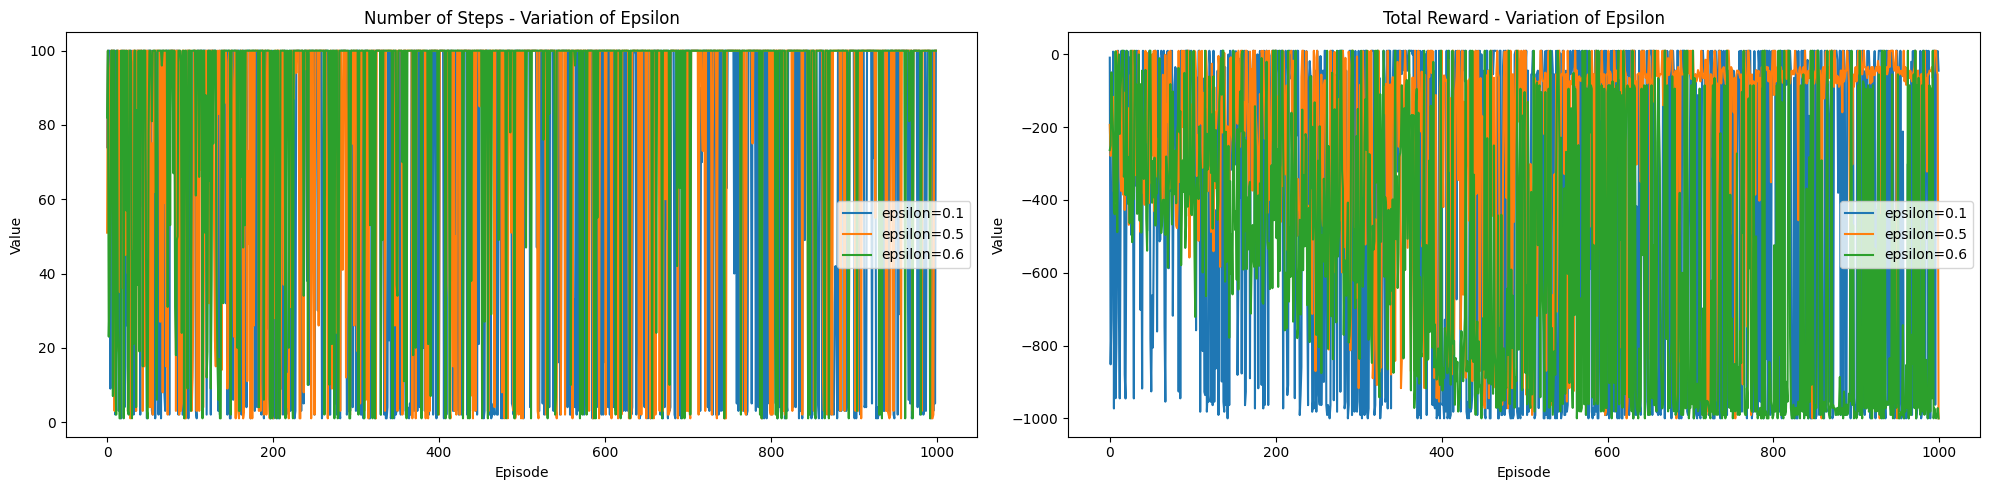

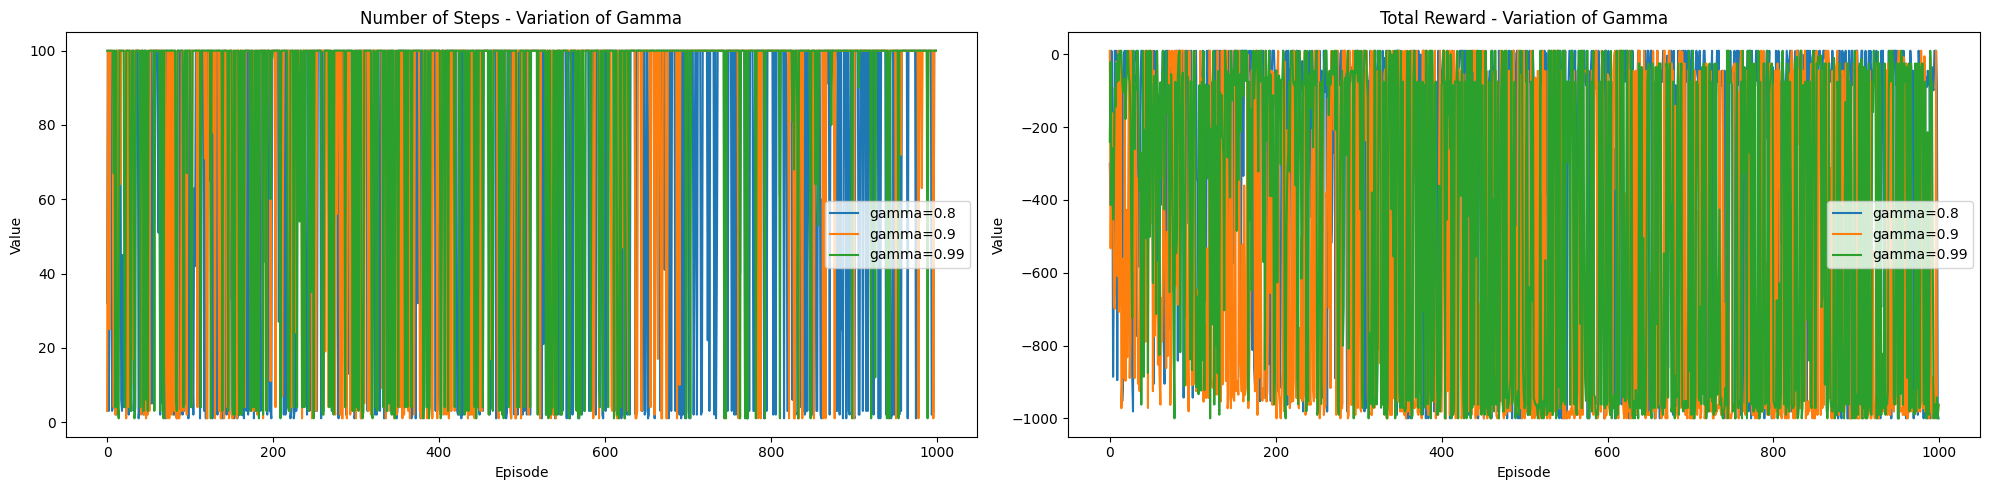

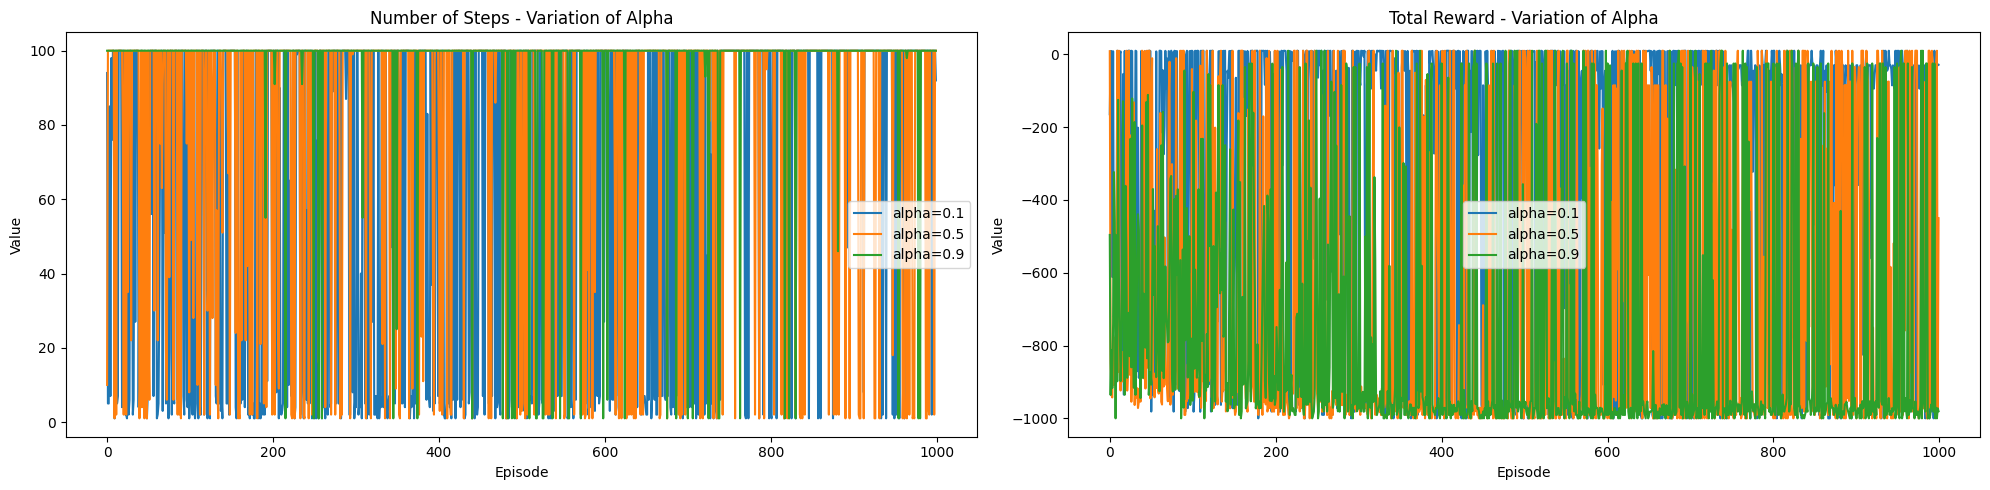

In [61]:
execute_and_analyze_agent(MonteCarloAgent, mazes[3], episodes= 1000)

Max reward in episode 3 with reward = 10
Min reward in episode 2 with reward = -117.19999999999997
Max steps in episode 2 with steps = 69
Min steps in episode 3 with steps = 1


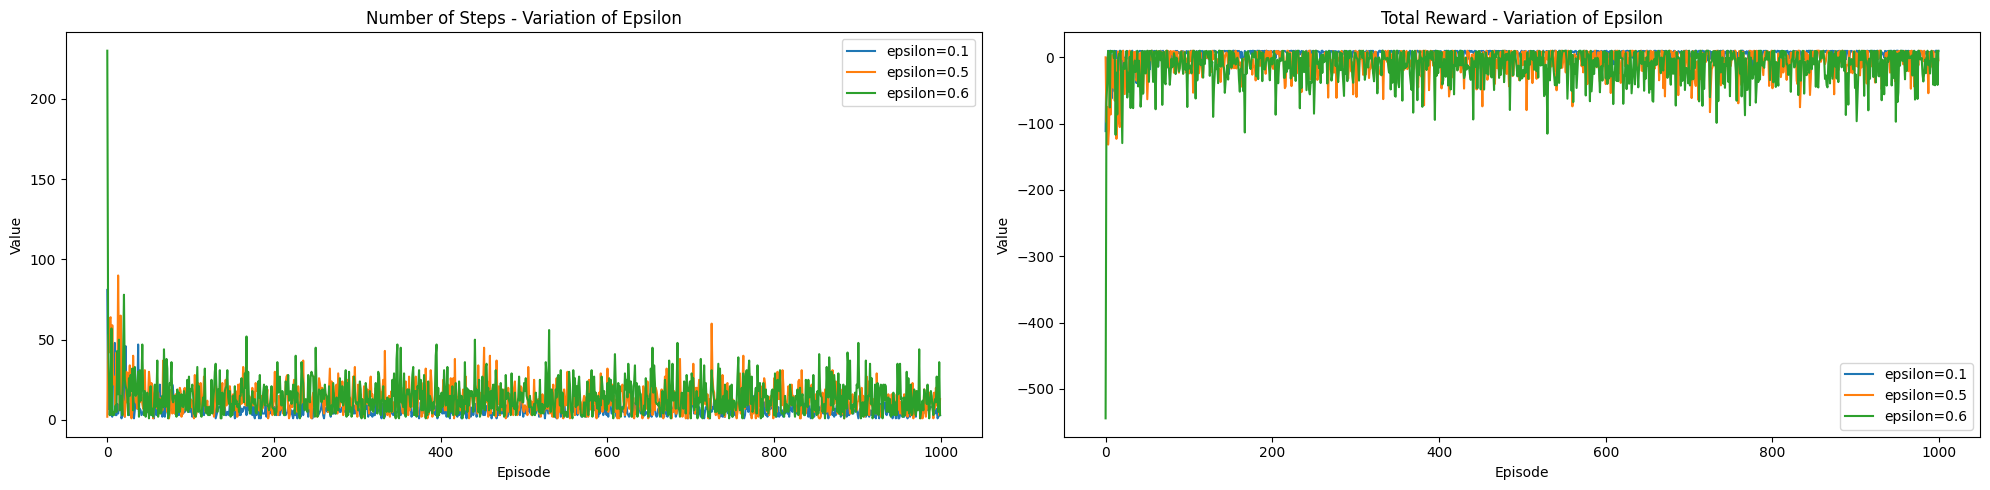

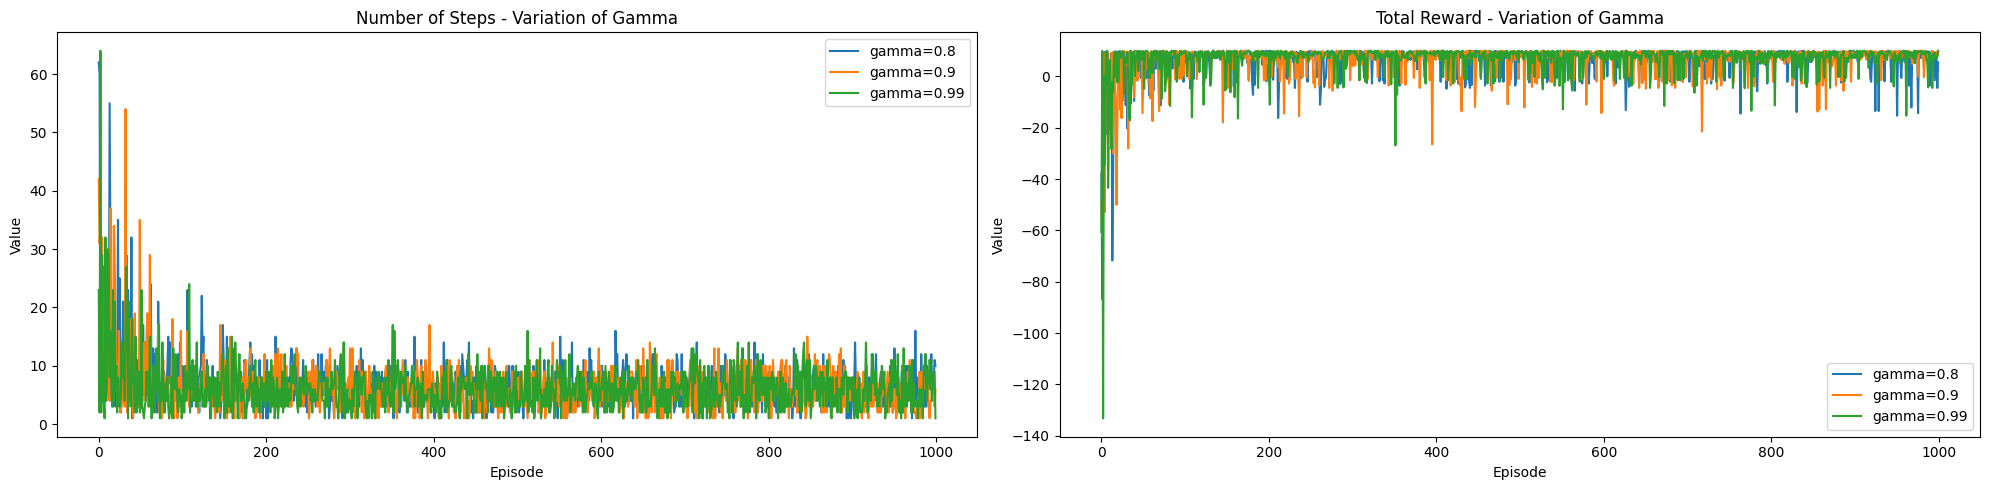

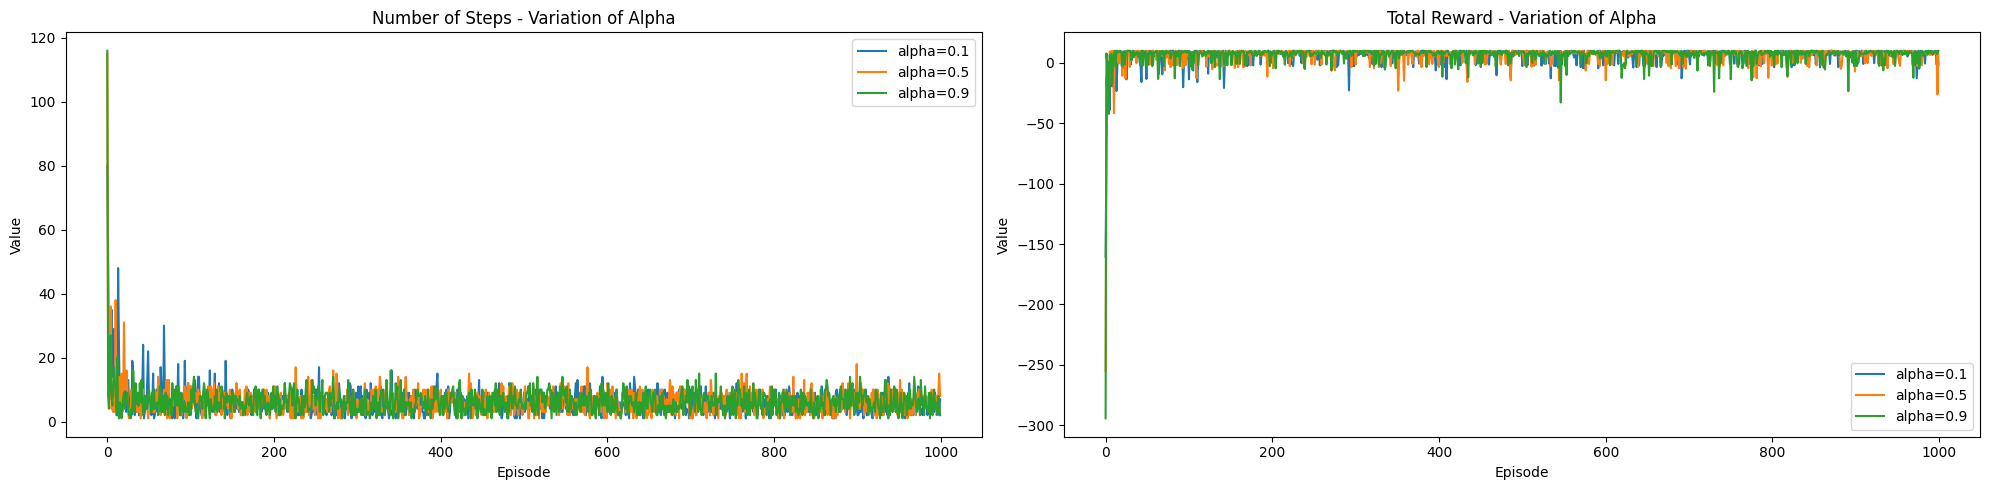

In [64]:
execute_and_analyze_agent(QLearningAgent, mazes[3])

Max reward in episode 25 with reward = 10
Min reward in episode 0 with reward = -307.7000000000001
Max steps in episode 0 with steps = 87
Min steps in episode 25 with steps = 1


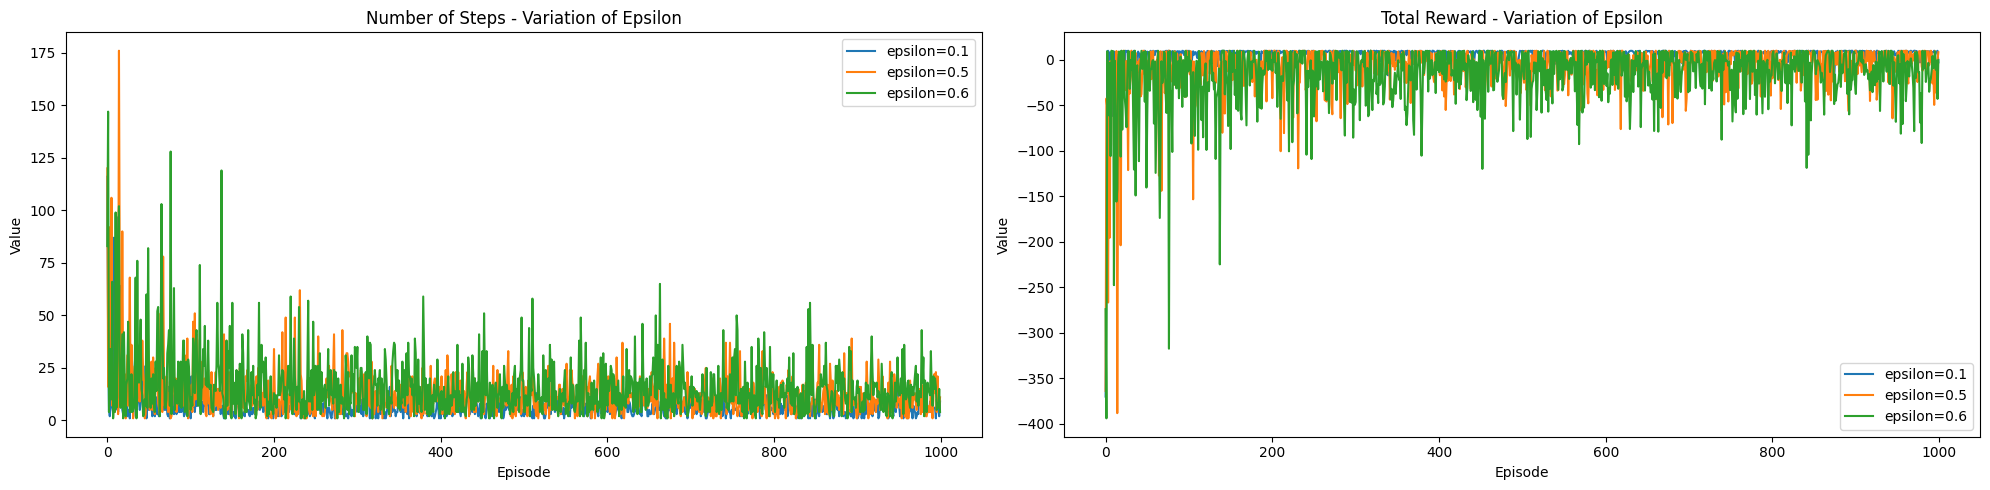

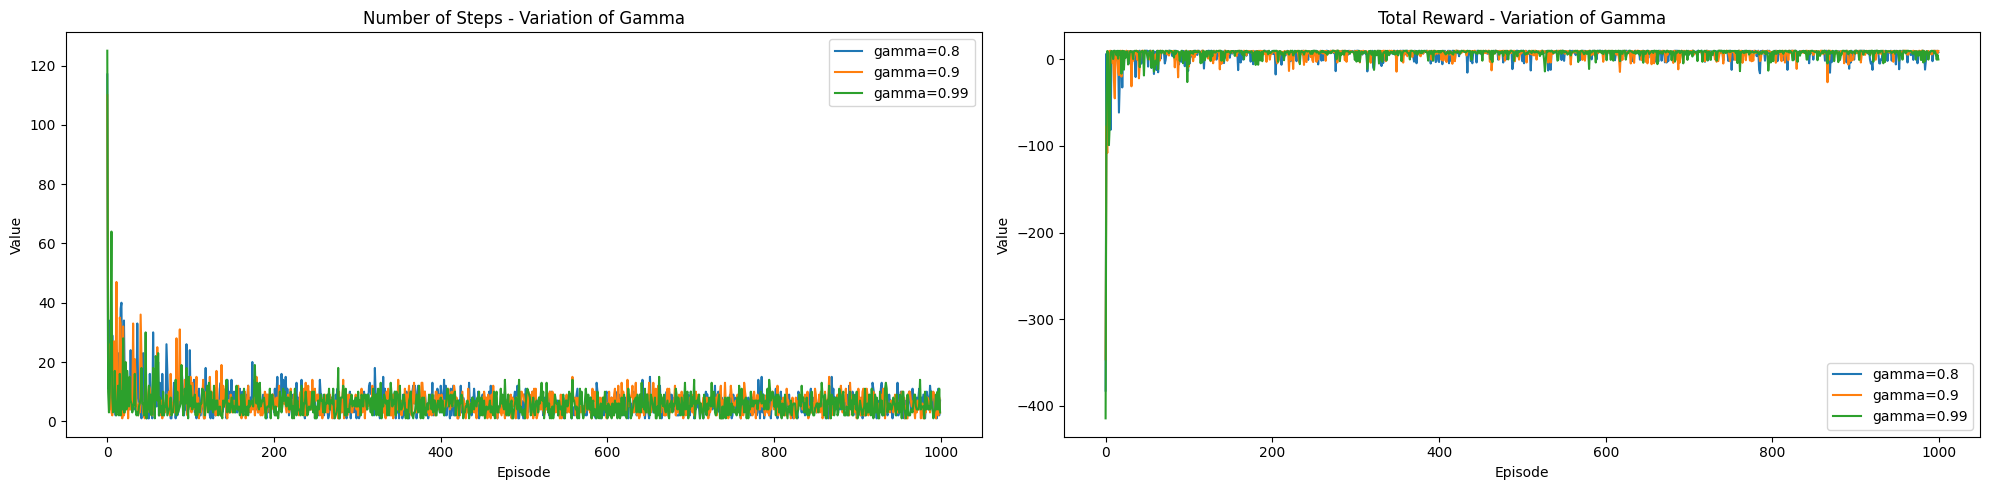

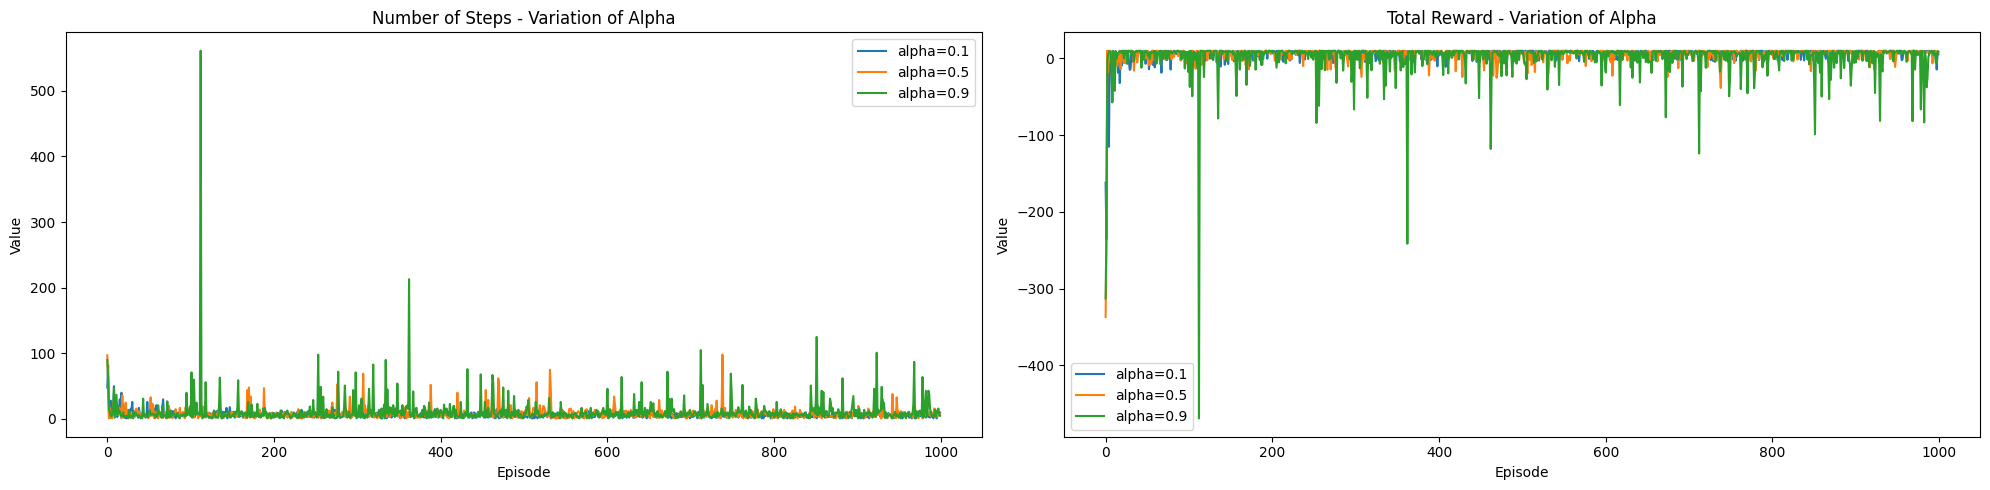

In [45]:
execute_and_analyze_agent(SARSAgent, mazes[3])

In [65]:
# Configurações iniciais
env = MazeGameEnv(maze)
agent = MonteCarloAgent(env)
agent_data = agent.train(1000, render=True, num_obstacles=0)

NameError: name 'sys' is not defined